# This notebook recalibrates the uncertainties of predictions, and compares them to the uncalibrated uncertainties in terms of calibration, sharpness, and dispersion.


In [1]:
'''First, we need to define the path of where to get the dataset, and define other parameters that we will need'''
import sys
sys.path.append('/Users/jakehirst/Desktop/sfx/sfx_ML_code/sfx_ML/New_Models')

from Bagging_models import *
from ReCalibration import *
from Backward_feature_selection import *
from Single_UQ_models import *
import ast

model_types = ['ANN', 'RF', 'GPR','ridge','Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']
# model_types = ['ANN', 'RF', 'GPR','ridge']
# model_types = ['Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']
# model_types = ['ridge']

all_labels = ['height', 'phi', 'theta', 
                            'impact site x', 'impact site y', 'impact site z', 
                            'impact site r', 'impact site phi', 'impact site theta']

num_models_list = [20]
labels_to_predict = ['impact site x', 'impact site y', 'height']
# labels_to_predict = ['impact site x']

with_or_without_transformations = 'with'
with_or_without_transformations = 'without'

Paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations'
if(not os.path.exists(Paper2_path)): os.makedirs(Paper2_path)
model_folder = Paper2_path + f'/UQ_bagging_models_{with_or_without_transformations}_transformations'
data_folder = Paper2_path + '/5fold_datasets'
results_folder = Paper2_path + '/Compare_Code_5_fold_ensemble_results'
hyperparam_folder = Paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'


image_folder = '/Users/jakehirst/Desktop/sfx/sfx_ML_data/images_sfx/new_dataset/Visible_cracks'

if(with_or_without_transformations == 'with'):
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
    backward_feat_selection_results_folder = '/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/results'
else:
    # full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 2/New_Crack_Len_FULL_OG_dataframe_2024_02_22.csv"
    backward_feat_selection_results_folder = Paper2_path + '/Paper_2_results_WITHOUT_feature_engineering/results' 
    df = pd.read_csv(full_dataset_pathname, index_col=0)
    all_features = df.columns
    all_features = all_features.drop(all_labels)
    all_features = str(all_features.drop('timestep_init').to_list())

    print(all_features)
 

print('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname)

'''get the appropriate features that each model will use based on backward feature elimination'''
all_features_to_keep = {}

min_features = 1 #minimum number of features you want to select from BFS (backward feature selection)
max_features = 25 #maximum number of features you want to select from BFS
for label in labels_to_predict:
    all_features_to_keep[label] = {}
    for model_type in model_types:
        
        if('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname):
            print('true')
        #TODO use code below if using feature selection
            best_features = get_best_features(backward_feat_selection_results_folder, label, model_type, min_features, max_features)
            all_features_to_keep[label][model_type] = best_features
        
        else:
            print('using just the basic features')
            #TODO use code below if NOT using feature selection
            all_features_to_keep[label][model_type] = all_features

print(all_features_to_keep)

forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'med

In [2]:
calibration_types = ['linear']


'''Now we will evaluate the performance of the bagging models'''
for calibration_type in calibration_types:
    for model_type in model_types:
        print(f'MODEL TYPE = {model_type}')
        for label_to_predict in labels_to_predict:
            print(f'LABEL = {label_to_predict}')
            for num_models in num_models_list:
                performance_data = []
                for fold_no in range(1,6):
                    print(f'fold {fold_no}')

                    #defining folders to get the models and to store the results
                    model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                    results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                    
                    #defining folders where the datasets are coming from (5-fold cv)
                    test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
                    test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
                    train_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_features.csv'
                    train_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_labels.csv'

                    #defining the features that each model used (since they vary with each model)
                    features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict][model_type])
                    
                    if(model_type in ['ANN', 'RF', 'GPR','ridge']):
                        #defining folders to get the models and to store the results
                        model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                        results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                        #predicting the test and train sets with the bagging models
                        test_r2, test_ensemble_predictions, test_uncertanties, test_labels = Get_predictions_and_uncertainty_with_bagging(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
                        train_r2, train_ensemble_predictions, train_uncertanties, train_labels = Get_predictions_and_uncertainty_with_bagging(train_features_path, train_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
                    else:
                        #defining folders to get the models and to store the results
                        model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
                        results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
                        #predicting the test and train sets with the NON bagging models
                        test_r2, test_ensemble_predictions, test_uncertanties, test_labels = Get_predictions_and_uncertainty(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
                        train_r2, train_ensemble_predictions, train_uncertanties, train_labels = Get_predictions_and_uncertainty(train_features_path, train_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)

                    #defining the residual errors of the predictions
                    train_labels_arr = train_labels.to_numpy().T[0]
                    train_predictions_arr = np.array(train_ensemble_predictions)
                    test_labels_arr = test_labels.to_numpy().T[0]
                    test_predictions_arr = np.array(test_ensemble_predictions)
                    train_residuals = pd.Series(np.abs(train_labels_arr - train_predictions_arr))
                    test_residuals = pd.Series(np.abs(test_labels_arr - test_predictions_arr))


                    '''
                    Calculating and plotting performance metrics as outlined in section 2.3 of Tran et al. (https://dx.doi.org/10.1088/2632-2153/ab7e1a)
                    
                    Models should be compared in terms of 
                    1st - accuracy (R^2) 
                    2nd - calibration (miscalibration area)
                    3rd - sharpness
                    4th - dispersion
                    '''
                    
                    saving_folder = 'none'
                    print('BEFORE CALIBRATION')
                    miscalibration_area, calibration_error = make_calibration_plots(model_type, test_predictions_arr, test_labels_arr, test_uncertanties, results_saving_folder,show=2)
                    print(f'Before calibration: miscal_area = {miscalibration_area}')
                    stdevs = np.array(test_uncertanties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
                    sharpness, dispersion = plot_sharpness_curve(stdevs, results_saving_folder, show=2)

                    a = 0
                    b = 0
                    '''getting calibration factors *** linear'''
                    if(calibration_type == 'linear'):
                        # linear_a, linear_b = get_linear_recalibration_factors(train_residuals, train_uncertanties)
                        linear_a, linear_b = get_linear_recalibration_factors(test_residuals, test_uncertanties)
                        calibrated_train_uncertainties = linear_calibrate_uncertainties(linear_a, linear_b, train_uncertanties)
                        calibrated_test_uncertainties = linear_calibrate_uncertainties(linear_a, linear_b, test_uncertanties)
                        
                        print('AFTER CALIBRATION')
                        miscalibration_area_calibrated, calibration_error_calibrated = make_calibration_plots(model_type, test_predictions_arr, test_labels_arr, calibrated_test_uncertainties, results_saving_folder,show=2)
                        print(f'After calibration: miscal_area = {miscalibration_area_calibrated}')
                        
                        #sharpness and dispersion
                        calibrated_stdevs = np.array(calibrated_test_uncertainties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
                        calibrated_sharpness, calibrated_dispersion = plot_sharpness_curve(calibrated_stdevs, results_saving_folder, show=2)
                    
                    
                    '''getting calibration factors *** Nonlinear'''
                    # elif(calibration_type == 'nonlinear'):
                    #     a, b = get_calibration_factors(train_residuals, train_ensemble_uncertanties)
                    #     print(f'a = {a} b = {b}')
                    #     calibrated_train_uncertainties = pd.Series(a * (train_ensemble_uncertanties**((b/2) + 1)), name='train_model_errors')
                    #     calibrated_test_uncertainties = pd.Series(a * (test_ensemble_uncertanties**((b/2) + 1)), name='test_model_errors')





                    '''collecting the performance data from this model'''
                    # performance_data.append([15, fold_no, train_r2, test_r2, a, b, train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope, miscalibration_area, calibration_error])
                    performance_data.append([fold_no, train_r2, test_r2, miscalibration_area_calibrated, calibration_error_calibrated, calibrated_sharpness, calibrated_dispersion])

                # columns = ['num bins', 'fold_no', 'train R2', 'test R2',  'a', 'b', 'train_intercept', 'train_slope', 'CAL_train_intercept', 'CAL_train_slope', 'train_intercept', 'test_slope', 'CAL_test_intercept', 'CAL_test_slope', 'miscal_area', 'cal_error']
                columns = ['fold_no', 'train R2', 'test R2', 'miscal_area', 'cal_error', 'sharpness', 'dispersion']
                df = pd.DataFrame(columns=columns)
                for row in performance_data:
                    df.loc[len(df)] = row
                average_row = df.mean()
                df = df.append(average_row, ignore_index=True)
                
                if(model_type in ['ANN', 'RF', 'GPR','ridge']):
                    results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/{num_models}_models'
                    df.to_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_{num_models}_CALIBRATED_{calibration_type}_results.csv', index=False)
                else:
                    results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models'
                    df.to_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_1_CALIBRATED_{calibration_type}_results.csv', index=False)

MODEL TYPE = ANN
LABEL = impact site x
fold 1
BEFORE CALIBRATION
Calibration error = 0.60
Before calibration: miscal_area = 0.07017676767676768
NLL optimization succeeded!
a = 0.6457334351770245 b = 4.215791157172122
AFTER CALIBRATION
Calibration error = 0.43
After calibration: miscal_area = 0.06047190656565657
fold 2
BEFORE CALIBRATION
Calibration error = 0.87
Before calibration: miscal_area = 0.08751736111111114
NLL optimization succeeded!
a = 0.6354920048866586 b = 2.5584958715872723
AFTER CALIBRATION
Calibration error = 1.21
After calibration: miscal_area = 0.1011537247474748
fold 3
BEFORE CALIBRATION
Calibration error = 0.66
Before calibration: miscal_area = 0.06724888689526849
NLL optimization succeeded!
a = 0.6809309273158776 b = 3.0913437027229325
AFTER CALIBRATION
Calibration error = 0.60
After calibration: miscal_area = 0.0640581664098614
fold 4
BEFORE CALIBRATION
Calibration error = 0.60
Before calibration: miscal_area = 0.0732007575757576
NLL optimization succeeded!
a = 0.5

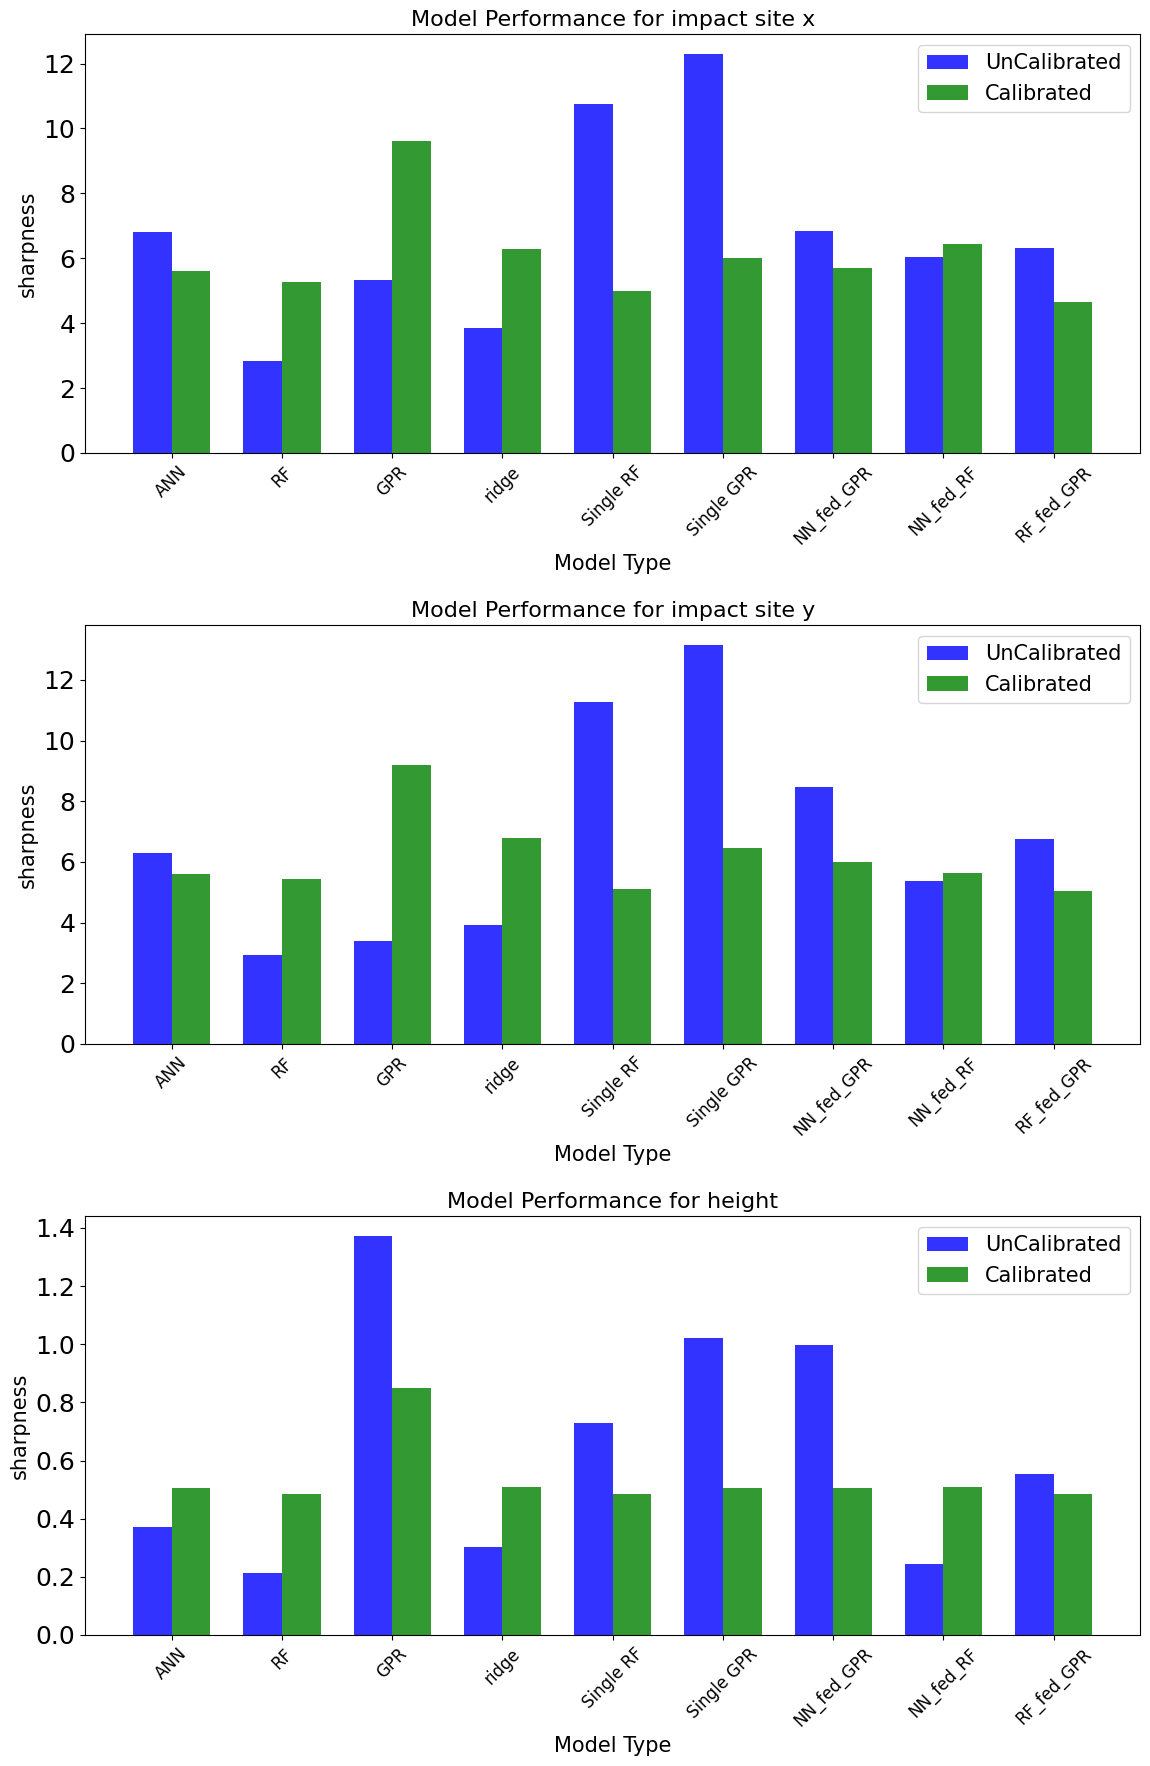

In [2]:
'''Now we can make plots to compare the results between the calibrated uncertainties and the uncalibrated uncertainties'''
calibration_types = ['linear']
num_models_in_bagging = 20
metric = 'miscal_area'
metric = 'sharpness'
# metric = 'dispersion'

for calibration_type in calibration_types:
    performance_data = {}
    for label_to_predict in labels_to_predict:
        performance_data[label_to_predict] = {}
        for model_type in model_types:
            performance_data[label_to_predict][model_type] = {} 
            
            if(model_type in ['ANN', 'RF', 'GPR','ridge']):
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/{num_models_in_bagging}_models'
                calibrated_df = pd.read_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_{num_models_in_bagging}_CALIBRATED_{calibration_type}_results.csv')
                UNcalibrated_df = pd.read_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_{num_models_in_bagging}results.csv')
            else:
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models'
                calibrated_df = pd.read_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_1_CALIBRATED_{calibration_type}_results.csv')
                UNcalibrated_df = pd.read_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_1results.csv')
            
            
            avg_row_uncal = UNcalibrated_df.iloc[5]
            avg_row_cal = calibrated_df.iloc[5]
            
            
            performance_data[label_to_predict][model_type]['UNcalibrated'] = avg_row_uncal[metric]
            performance_data[label_to_predict][model_type]['calibrated'] = avg_row_cal[metric]

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18)) 

    labels = list(performance_data.keys())  # Labels to predict
    model_types = list(performance_data[labels[0]].keys())  # Model types
    num_models = len(model_types)
    index = np.arange(num_models)
    bar_width = 0.35
    opacity = 0.8


    for i, label in enumerate(labels):
        calibrated_scores = [performance_data[label][model]['calibrated'] for model in model_types]
        uncalibrated_scores = [performance_data[label][model]['UNcalibrated'] for model in model_types]

        axs[i].bar(index, uncalibrated_scores, bar_width, alpha=opacity, color='b', label='UnCalibrated')
        axs[i].bar(index + bar_width, calibrated_scores, bar_width, alpha=opacity, color='g', label='Calibrated')

        axs[i].set_xlabel('Model Type', fontsize=15)
        axs[i].set_ylabel(metric, fontsize=15)
        axs[i].set_title(f'Model Performance for {label}', fontsize=16)
        axs[i].set_xticks(index + bar_width / 2)
        axs[i].set_xticklabels(model_types, fontsize=12, rotation=45)
        axs[i].legend(fontsize=15)

    plt.subplots_adjust(hspace=0.3)  # Adjust space between plots to prevent overlap
    plt.show()

                
                
                
                
